In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# I modified this from code I found on stackoverflow
# 1. Fit a linear model to the dataset and subtract this from the data
# 2. Compute the discrete fourier transform of the dataset
# 3. The domain of the DFT is a set of frequencies. Pick the `n_harm` lowest frequencies and reassemble them into a signal
# 4. To reconstitute the signal, determine the amplitude and phase from the complex numbers in the DFT
def fourierExtrapolation(x, n_predict, n_harm):
    # x is an array of past data
    # n_predict is how many data points we want to predict for the future
    # n_harm is the number of harmonics in model
    n = x.size                          # Get the length of the data array
    t = np.arange(0, n)                 # Create a domain for the data
    slope = np.polyfit(t, x, 1)[0]      # Fit a linear trendline on the relationship between t and x
    detrended_x = x - slope * t         # Subtract the linear trendline from the data array
    dft = fft.fft(detrended_x)          # Compute DFT
    f = fft.fftfreq(n)                  # Get the set of frequencies in the domain of the DFT
    indices = np.argsort(np.abs(f))     # Create a list of DFT indices sorted by abs() of their frequency
    
    # Select only the lowest frequencies (to eliminate noise)
    low_freq = indices[: 1 + n_harm * 2]
 
    t = np.arange(0, n + n_predict)     # Create a domain for the reconstituted signal
    
    restored_sig = np.zeros(len(t))
    for i in low_freq:                  # Iterate over the low frequencies we selected
        # Calculate the amplitude and phase of the oscillation
        amplitude = np.absolute(dft[i]) / n
        phase = np.angle(dft[i])
        # Add a new layer of oscillation corresponding to this frequency
        restored_sig += amplitude * np.cos(2 * np.pi * f[i] * t + phase)
    # Reintroduce the linear trend we determined earlier
    return restored_sig + slope * t

In [10]:
data = pd.read_csv("../sample_data/19992009electricitybyplanningarea.csv")
data = data[data["Planning Area Description"] == "Burbank, Glendale, and Pasadena"].sort_values("Year")
data = data[:-1]

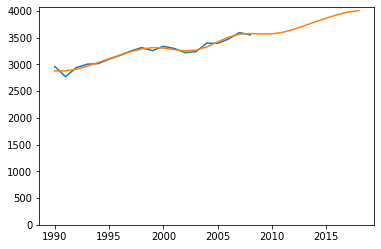

In [11]:
# Predict next 10 years 
n_predict = 10
# Compute the extrapolation
extrapolation = fourierExtrapolation(data["Total Usage"], n_predict, 3)
# Get the year after the last year in the dataset (the first predicted year)
start = np.array(data["Year"])[-1]+1
# Concatenate the past and predicted domains
x = np.append(np.array(data["Year"]), np.arange(start, start + n_predict))

# Plot the data
fig, ax = plt.subplots()
past, = ax.plot(data["Year"], data["Total Usage"])
pred, = ax.plot(x, extrapolation)
ax.set_ylim(0)
plt.show()